Module 5, Lab 1 - Correlation
=============================

This final series of labs explores everything you need to execute
projects from start to finish based on a few different analyses.

In this lab, we will explore how to assess relationships between
variables using correlation in R.

In this example, we have a dataset, inspired by a dataset published on
kaggle (<https://www.kaggle.com/unsdsn/world-happiness>). In this
dataset, several regions of the world are compared on dimensions such as
their generosity, happiness, GDP, and so forth.

Load Packages
=============

In this lab, we will use the `ggplot2` package for data visualization,
the `corrplot` package for making visual correlation tables, and the
`psych` package for detecting skew and making correlation matrices.

In [1]:
## Load packages
import pandas as pd
import numpy as np
import scipy.stats as ss
import math
import scipy.cluster.hierarchy as sch
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Load Data
=========

Next, let's load the data.

In [2]:
#### LOAD DATA ####
dat = pd. read_csv("datasets/regionalhappy.csv")

Inspecting the dataset, we see the names are a little messy:

In [3]:
dat.columns

Index(['Happiness.Score', 'Economy..GDP.per.Capita.', 'Family',
       'Health..Life.Expectancy.', 'Freedom', 'Generosity',
       'Trust..Government.Corruption.', 'Dystopia.Residual'],
      dtype='object')

We can rename them easily by assigning names to the `columns` attribute of the data frame:

In [4]:
dat.columns = ["Happiness", "GDP", "Family", "Life_Expect", "Freedom", "Generosity", "Trust_Gov", "Dystopia"]
dat.columns

Index(['Happiness', 'GDP', 'Family', 'Life_Expect', 'Freedom', 'Generosity',
       'Trust_Gov', 'Dystopia'],
      dtype='object')

Let's look at the first few rows of the data:

In [5]:
dat.head()

,Happiness,GDP,Family,Life_Expect,Freedom,Generosity,Trust_Gov,Dystopia
0,7.537,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,7.522,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,7.504,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,7.494,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,7.469,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


Much better.

Bivariate Correlation
=====================

Next, let's see how variables correlate. In our research study, we want
to understand happiness. We can compute correlations between variables
with the Pandas `corr()` method. The upper or lower off-diagonal elements of the 2X2 correlation matrix contain the correlation coefficients. The Pandas `iloc` method allows you to address these elements using numerical indicies. 

In [6]:
corr_mat = dat[['Happiness', 'Life_Expect']].corr()
corr_mat.iloc[1,0].round(3)

0.78200000000000003

We see the correlation is *r* = .78. A brief refresher: correlations
range between zero (no association between variables) and 1.0 (a
one-to-one association). They can also be positive (as one variable
increases, so does the other) or negative (as one variable increases,
the other decreases).

So, in this case, we have a large, positive link between the happiness
of a region and health / life expectancy in that region. The
statistician Jacob Cohen suggested the following guidelines:

|        | Correlation          | Meaning  |
| ------------- |:-------------:|-----------:|
| 1.  | 0 - 0.1 | Negligible |
| 2.  | 0.1 - 0.3     |  Small |
| 3. | 0.3 - 0.5      |  Medium |
| 4. | 0.50 +      |  Large |

We see, then, that this association would count as "large" by Cohen's
guidelines.

We can also easily visualize this correlation with `ggplot2`:

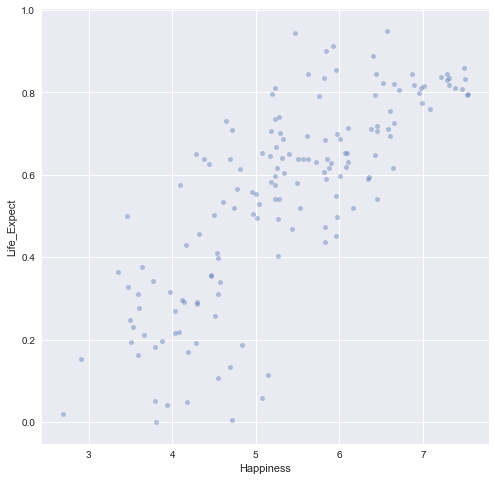

In [7]:
ax = plt.figure(figsize=(8, 8)).gca() # define axis
dat.plot.scatter(x = 'Happiness', y = 'Life_Expect', ax = ax, alpha = 0.4)



### A Sample Estimate

We have discussed statistical hypothesis testing a number of times in
this course, but we haven't yet discussed it in detail with respect to
correlations. So, here is a brief refresher on the need for significance
testing, applied to correlation.

Here, are working with a sample of regions at one point in time. What if
we wanted to estimate, in a broader way, the association between
happiness and life expectancy? Assuming our data are representative of
the broader population (e.g., across times, regions, etc.; a big
assumption!), we could use this sample correlation (symbol: *r* = .78)
as an estimate of the population correlation (symbol: *ρ*). In other
words, we don't know the true correlation between happiness and life
expectancy in the population, but if we can trust this data to
adequately represent it, we can *estimate* it at .78.

The estimation piece is important. Often, people look at the sample
correlation and don't realize that it's specific to that sample. For
example, an organization might collect a survey to assess the link
between customer satisfaction and consumption. Whatever correlation
observed in the sample is only an estimate--our best guess--of the
correlation in the broader population. Were that organization to collect
another sample, they would get a different correlation. Every time, the
correlation would vary slightly, because the sample is different and
only representing (but not being) the population. This raises an
important point: sample correlations are imperfect estimates of their
population counterparts. The sample estimate has error built into it.

One important consequence is that it is possible that the correlation in
the population is actually zero (*H*<sub>0</sub> : *ρ* = 0) even when it
is not in the sample (e.g., *r* = .12). In other words, the sample
correlation could be a statistical fluke of the sample. We cannot say,
just because the sample correlation is nonzero, that the two variables
truly are correlated in the population. We will need to conduct a
statistical significance test first.

Further, we can *only* trust the sample correlation as an estimate of
the population correlation *if* the data are representative. If only a
certain kind of person selects into the survey (e.g., a certain
personality type, people who have strong feelings about a product,
etc.), then the sample correlation will estimate the correlation for
*that population only.* This essentially means that all research data is
biased toward whoever is over-represented in the sample. For this
reason, getting good information on whoever is represented in one's data
is very important for qualifying the results. In some cases, it may be
worth it to gather data from multiple different sources or methods and
cross-reference the results for very important decisions.

Significance Test
=================

If we want to test the correlation for significance, we can use the 'pearsonr' function from the scipy.stats modules. The confidence intervals can be computed using the methods in the functions below.

In [8]:
def r_z(r): ## transform distribution
    return math.log((1 + r) / (1 - r)) / 2.0

def z_r(z): ## inverse transform distribution 
    e = math.exp(2 * z)
    return((e - 1) / (e + 1))

def r_conf_int(r, alpha, n):
    # Transform r to z space
    z = r_z(r)
    # Compute standard error and critcal value in z
    se = 1.0 / math.sqrt(n - 3)
    z_crit = ss.norm.ppf(1 - alpha/2)

    ## Compute CIs with transform to r
    lo = z_r(z - z_crit * se)
    hi = z_r(z + z_crit * se)
    return (lo, hi)

def correlation_sig(df, col1, col2):
    pearson_cor = ss.pearsonr(x = df[col1], y = dat[col2])
    conf_ints = r_conf_int(pearson_cor[0], 0.05, 1000)
    print('Correlation = %4.3f with CI of %4.3f to %4.3f and p_value %4.3e' 
        % (pearson_cor[0], conf_ints[0], conf_ints[1], pearson_cor[1]))
    
correlation_sig(dat, 'Happiness', 'Life_Expect')    

Correlation = 0.782 with CI of 0.757 to 0.805 and p_value 3.213e-33


The confidence interval is fairly narrow around the correlation coefficient. 

Using the same information, we can make a reasonable guess about what
the correlation in the population is. We see that `cor.test()` has given
us a 95% confidence interval of \[0.71, 0.84\], meaning that we are 95%
confident that the population value (*ρ*) is in that range. By "95%
confident," we mean that this range includes the population value 95% of
the time. If we act on it and trust it, we are right 95% of the time.

So, we are pretty certain that, even though we have a sample (a small
sample, too!), that there is a large correlation in the population
between happiness and life satisfaction. Even after taking the
uncertainty of our sample into account (e.g., with the *t*-test and 95%
CI), we still feel confident that there is a larger link between these
two variables.

Caveat: Normality
=================

It should be noted that correlations work best with normally distributed
(bell curve, symmetrical) data. We can briefly check the skew of the
variables:

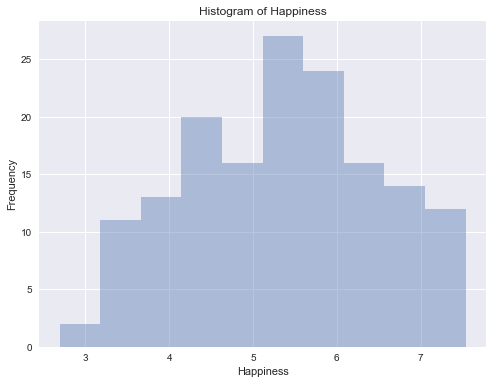

In [9]:
ax = plt.figure(figsize=(8, 6)).gca() # define axis
dat.Happiness.plot.hist(ax = ax, alpha = 0.4)
plt.title('Histogram of Happiness')
plt.xlabel('Happiness')

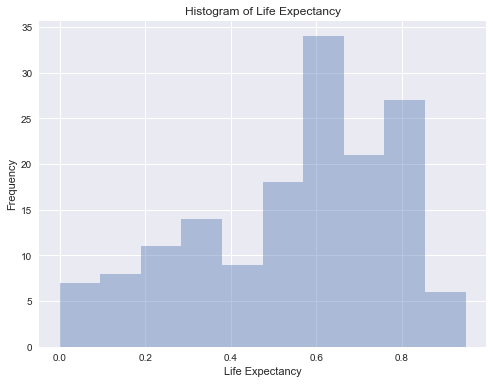

In [10]:
ax = plt.figure(figsize=(8, 6)).gca() # define axis
dat.Life_Expect.plot.hist(ax = ax, alpha = 0.4)
plt.title('Histogram of Life Expectancy')
plt.xlabel('Life Expectancy')


We see here that both variables are decently normally distributed, but
life expectancy is possibly negative skewed (i.e., "skew left"). We can
get a metric of the skew using the `skewtest()` function from the Scipy.Stats
package:

In [11]:
skew = ss.skewtest(dat.Happiness)
skew

SkewtestResult(statistic=0.050183426045015717, pvalue=0.95997621901171126)

People disagree about what is acceptable skew, but usually a value less
than +/- 1.0 raises no alarms. Further, the p-value is rather large indicating we cannot reject the null hypothesis that there is no skew. Here, we can safely go about our
business.

However, if we had a bigger skew problem, we could also address the skew
by transforming the variable. (There are also backup options, such as
Spearman's correlation, but we won't explore that in this class beyond
what was covered in Module 3).

Correlations are based on variance, so anything that biases a mean
(e.g., skew) also interferes with the correlation. In general, skew
reduces correlations. For a more robust test of the correlation, you can
transform the data by performing a mathematical operation to every
score. There are many such operations we can try. In general, taking the
square root of every score reduces skew, but the catch is that the
variable must be positively skewed and no scores may be negative. For
the sake of illustration, let's try this.

First, let's "reverse" the variable. Take the maximum score, add one to
it, and subtract your score:

In [13]:
dat['Life_Expect2']= max(dat.Life_Expect) + 1 - dat.Life_Expect

This reverses the variable as shown in the histogram:

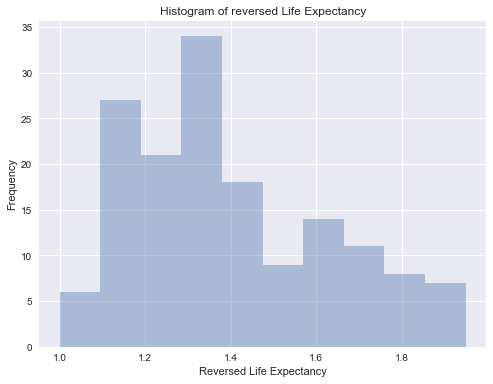

In [14]:
ax = plt.figure(figsize=(8, 6)).gca() # define axis
dat.Life_Expect2.plot.hist(ax = ax, alpha = 0.4)
plt.title('Histogram of reversed Life Expectancy')
plt.xlabel('Reversed Life Expectancy')

![](Mod3_Lab1_-_Correlation_files/figure-markdown_strict/unnamed-chunk-13-1.png)

Now we can perform any number of operations. The square root is the most
mild transformation. We can also take the natural log of every score (no
values may be zero!). In general, these operations reduce big numbers
more than small numbers and thus rein in the long tail. The Pandas `apply` method is used to apply the `math.sqrt` function to each element of `Life_Expect2`.

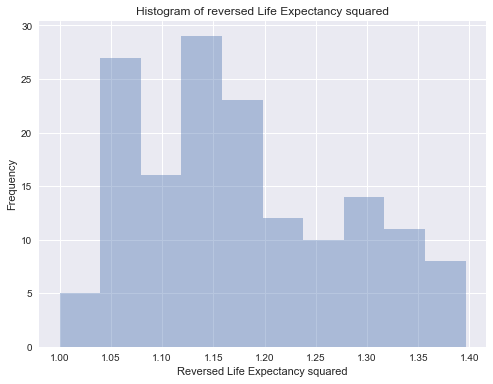

In [15]:
## Square the reversed variable
dat['Life_Expect2_sqrt'] = dat.Life_Expect2.apply(math.sqrt)

ax = plt.figure(figsize=(8, 6)).gca() # define axis
dat.Life_Expect2_sqrt.plot.hist(ax = ax, alpha = 0.4)
plt.title('Histogram of reversed Life Expectancy squared')
plt.xlabel('Reversed Life Expectancy squared')

![](Mod3_Lab1_-_Correlation_files/figure-markdown_strict/unnamed-chunk-14-1.png)
We could save this transformed version, then re-reverse it and use that
in subsequent analyses.

In [16]:
## un-reverse the variable
dat['Life_Expect2']= max(dat.Life_Expect2_sqrt) + 1 - dat.Life_Expect2_sqrt

## compute correlation of new variable and test statistics
correlation_sig(dat, 'Happiness', 'Life_Expect2')  

Correlation = 0.786 with CI of 0.762 to 0.809 and p_value 7.978e-34


We see here the results barely changed. In this case, that wasn't really
necessary because the variable was not that skewed to begin with. You
will find, in many cases, that it is very helpful, however. In those
cases, there are many online guides to data transformation.

Of course, if you are predicting something that has a very non-normal
distribution (e.g., categorical variables, counts of things often have
many zeros, etc.) then correlation may not be the best tool to use. A
more sophisticated data modeling technique may be warranted. However,

Correlations Among Many Variables
=================================

Often we want to examine the correlations among many variables at once.
In this case, we could look at a matrix of correlations. This can be
done using the `corr()` method on a pandas data frame. You can use the entire data frame of subset it. In this case we just want the correlations between happiness, life
expectancy, GDP, and generosity. Notice the double `[[]]` the outer `[]` is the subset operator and the inner `[]` delimits the list of column names:

We can easily see that happiness, life expectancy, and GDP are all
highly intercorrelated, whereas generosity is seemingly less related.
Thus, we may conceive that we have a "cluster" of intercorrelated
variables around happiness.

In [17]:
dat[['Happiness', 'Life_Expect', 'Generosity']].corr()

,Happiness,Life_Expect,Generosity
Happiness,1.000000,0.781951,0.155256
Life_Expect,0.781951,1.000000,0.063191
Generosity,0.155256,0.063191,1.000000


We can see that generosity is not significantly correlated with the other
variables.

#### Clustering

We saw before we had a cluster of several overlapping variables. We can
make some helpful visuals to view this cluster. The code in the cell below performs the following processing:
1. The correlation matrix is computed using the Pandas `corr` method and with two unneeded columns dropped from the data frame. 
2. A hierarchical clustering model is constructed using methods from the scipy.cluster.hierarchy package. A hierarchical cluster model is created by linking (using a `linkage` function) values based on a measure of distance into a hierarchy or tree. The details of hierarchical clustering are beyond the scope of this course. 
3. The correlation matrix is permuted based on the hierarchy and plotted as a heat map. 

Execute the code below and examine the results:

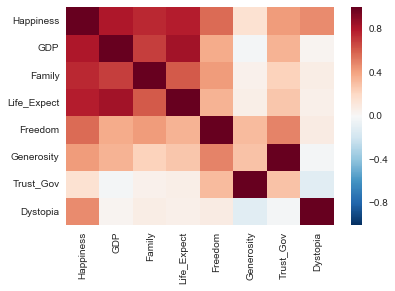

In [18]:
## Compute the correlation matrix
corrs = dat.drop(['Life_Expect2', 'Life_Expect2_sqrt'], axis = 1).corr()

## Create the hierarchical clustering model
dist = sch.distance.pdist(corrs)   # vector of pairwise distances using correlations
linkage = sch.linkage(dist, method='complete') # Compute the linkages for the clusters
ind = sch.fcluster(linkage, 0.5*dist.max(), 'distance')  # Apply the clustering algorithm

## Order the columns of the correlaton matrix according to the hierarchy
columns = [corrs.columns.tolist()[i] for i in list((np.argsort(ind)))]  # Order the names for the result
corrs_clustered = corrs.reindex(columns) ## Reindex the columns following the heirarchy 

## Plot a heat map of the clustered correlations
sns.heatmap(corrs_clustered, 
            xticklabels=corrs_clustered.columns.values,
            yticklabels=corrs_clustered.columns.values)

Here we see there is a prominent cluster of happiness, family, life
expectancy, and GDP. These are all highly inter-correlated. You can see
this from the bright spot in the heat map.

#### Another Correlation Plot

With small number variables, it can be useful to display the correlation matrix with the numerical values. The Pandas `style.background_gradient()` does just this:

In [19]:
corrs_clustered.style.background_gradient().set_precision(2)

,Happiness,GDP,Family,Life_Expect,Freedom,Generosity,Trust_Gov,Dystopia
Happiness,1,0.81,0.75,0.78,0.57,0.16,0.43,0.48
GDP,0.81,1,0.69,0.84,0.37,-0.019,0.35,0.024
Family,0.75,0.69,1,0.61,0.42,0.052,0.23,0.071
Life_Expect,0.78,0.84,0.61,1,0.35,0.063,0.28,0.055
Freedom,0.57,0.37,0.42,0.35,1,0.32,0.5,0.082
Trust_Gov,0.43,0.35,0.23,0.28,0.5,0.29,1,-0.023
Generosity,0.16,-0.019,0.052,0.063,0.32,1,0.29,-0.12
Dystopia,0.48,0.024,0.071,0.055,0.082,-0.12,-0.023,1


The darker the color, the higher the correlation. The lightest colors are negative correlations. 

Notice that several variables exhibit correlations quite close to 0. It is a good idea to see if these correlations are even significant. 

![](Mod3_Lab1_-_Correlation_files/figure-markdown_strict/unnamed-chunk-20-1.png)

We can also add a grid of *p*-values with `p.mat=` and tell the function
to "X" out anything not &lt; .05 by adding `sig.level = .05`:

In [20]:
def correlation_sig2(df, col1, col2):
    pearson_cor = ss.pearsonr(x = df[col1], y = dat[col2]) 
    conf_ints = r_conf_int(pearson_cor[0], 0.05, 1000)
    print('Correlation with ' + col2 + ' = %4.3f with CI of %4.3f to %4.3f and p_value %4.3e' 
        % (pearson_cor[0], conf_ints[0], conf_ints[1], pearson_cor[1]))

def test_significance(df, col_list):
    cols = df.columns
    for col1 in col_list: 
        print('\n')
        print('Significance of correlations with ' + col1)
        for col2 in cols: 
            if(col1 != col2):
                correlation_sig2(df, col1, col2)  

test_cols = ['Trust_Gov', 'Generosity', 'Dystopia']
test_significance(dat, test_cols)



Significance of correlations with Trust_Gov
Correlation with Happiness = 0.429 with CI of 0.377 to 0.478 and p_value 2.538e-08
Correlation with GDP = 0.351 with CI of 0.295 to 0.404 and p_value 7.567e-06
Correlation with Family = 0.232 with CI of 0.172 to 0.290 and p_value 3.700e-03
Correlation with Life_Expect = 0.280 with CI of 0.222 to 0.336 and p_value 4.229e-04
Correlation with Freedom = 0.499 with CI of 0.451 to 0.544 and p_value 3.810e-11
Correlation with Generosity = 0.294 with CI of 0.236 to 0.350 and p_value 2.031e-04
Correlation with Dystopia = -0.023 with CI of -0.085 to 0.039 and p_value 7.787e-01
Correlation with Life_Expect2 = 0.291 with CI of 0.233 to 0.347 and p_value 2.364e-04
Correlation with Life_Expect2_sqrt = -0.291 with CI of -0.347 to -0.233 and p_value 2.364e-04


Significance of correlations with Generosity
Correlation with Happiness = 0.155 with CI of 0.094 to 0.215 and p_value 5.373e-02
Correlation with GDP = -0.019 with CI of -0.081 to 0.043 and p_value 8

Most the the correlations with Trust_Gov are significant. However, most correlations with Generosity and Dystopia are not. The lack of significance can been seen by confidence intervals that straddle 0.0 and have large p-values. 

There you have it. There are many great ways to illustrate correlations
among data.

Conclusion
==========

Using the correlation analysis, we have both learned to find clusters of
relationships among data and to estimate individual correlations and
test them for significance. If we had a specific variable we wanted to
study in greater detail, we could graduate to regression, which we will
do in the next lab.